Notebook to build 2 layer neural network from scratch and with Keras

# Project definition

Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
import pickle

In [2]:
cols_input= pickle.load(open('../data/cols_input.sav','rb'))

In [4]:
# load the data
df_train_all = pd.read_csv('../data/df_train_all.csv')
df_train = pd.read_csv('../data/df_train.csv')
df_valid = pd.read_csv('../data/df_valid.csv')

In [5]:
#make X matrices
X_train_all = df_train_all[cols_input].values
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train[['OUTPUT_LABEL']].values
y_valid = df_valid[['OUTPUT_LABEL']].values

X_train.shape, y_train.shape

((15766, 143), (15766, 1))

# Feature Engineering

Most of the feature engineering was completed in our prior project (https://github.com/andrewwlong/diabetes_readmission), but we need to fill in missing values and scale our features. For simplicity, we will fill missing values with the mean and scale the data to zero mean and unit variance. 

In [6]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean.fit(X_train_all)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [7]:
X_train_all_tf = imp_mean.transform(X_train_all)
X_train_tf = imp_mean.transform(X_train)
X_valid_tf = imp_mean.transform(X_valid)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_all_tf)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
X_train_all_tf = scaler.transform(X_train_all_tf)
X_train_tf = scaler.transform(X_train_tf)
X_valid_tf = scaler.transform(X_valid_tf)


# From Scratch

In [10]:
len(cols_input)

143

Here we would like to build a simple two-layer neural network from scratch using the structure introduced by Eric Ma:
    - Model
    - Loss function
    - Optimization Routine
    
For notation, I will try to stick to the notation introduced by Andrew Ng in his Coursera specialization (https://www.coursera.org/specializations/deep-learning). 

# Model

The model we will use is a two-layer neural network as shown below:
    ![title](../img/model.png)

Here we will have n_x input variables, n_1 hidden nodes and an output node. For this model we will use logistic regression $\sigma(z)$ for the hidden and output nodes. 

$\sigma(z) = \frac{1}{1-exp(-z)}$

In [11]:
def logistic(z):
    # vectorized logistic function
    return 1 / (1 + np.exp(-z))

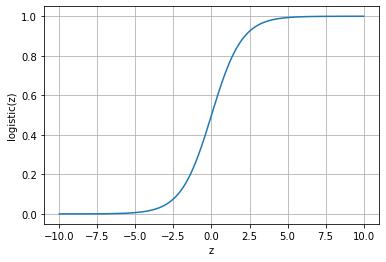

In [12]:
z = np.linspace(-10,10,1000)
plt.plot(z, logistic(z),'-')
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.grid(True)
plt.show()

Our logistic model will follow the form:

$a = \sigma(z)$
where $z = W X + b$

Here we will use vectorized notation for more efficient algorithms. 

In this notation, the first column of X will be all of features for a single sample. 

Here, let's say we have `m` samples. 

The parameters we will use for this model with dimensions in curly braces are:

$W^{[1]} \quad \{n_1, n_x \}$

$b^{[1]} \quad \{n_1, 1 \}$

$W^{[2]} \quad \{1, n_1 \}$

$b^{[2]} \quad \{1, 1 \}$

Let's initialize our parameters in a dictionary with random inputs.

In [13]:
nx = len(cols_input)
print(nx)

143


Let's choose 64 hidden nodes:

In [14]:
n1 = 64

In [15]:
params = dict()
params['W1'] = np.random.randn(n1,nx)
params['b1'] = np.random.randn(n1,1)
params['W2'] = np.random.randn(1,n1)
params['b2'] = np.random.randn(1,1)

The equations (with dimensions in curly braces) we need to calculate our $\hat{y}$ (estimate of y) are:

$A^{[0]} = X \quad \{n_x,m\}$

$Z^{[1]} = W^{[1]} A^{[0]} + b^{[1]} \quad \{n_1, m\}$

$A^{[1]} = \sigma(Z^{[1]}) \quad \{n_1, m\}$

$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]} \quad \{ 1,m \}$

$A^{[2]} = \sigma(Z^{[2]}) \quad \{ 1,m \}$

$\hat{Y} = A^{[2]} \quad \{ 1,m \}$

Let's define a feedforward function that allows us to calculate all the As. Here will assume that X has features as columns and rows as samples. Andrew Ng's notation transposes this which we can do in this feedforward function. 

In [16]:
def feedforward_2layer(params, act, X):
    # feedforward equations for 2 layer neural network using activation function act for hidden layer
    
    
    
    #input layer
    A0 = X.T # transpose for consistency with Andrew Ng
    # hidden layer
    Z1 = np.dot(params['W1'], A0) + params['b1']
    A1 = act(Z1)
    # output layer
    Z2 = np.dot(params['W2'], A1) + params['b2']
    A2 = logistic(Z2)

    # make a dictionary of values
    ff = dict()
    ff['A0'] = A0 
    ff['A1'] = A1
    ff['A2'] = A2
    ff['Z1'] = Z1
    ff['Z2'] = Z2
    return ff

In [17]:
X_train_tf.shape

(15766, 143)

In [18]:
ff = feedforward_2layer(params, logistic, X_train_tf)

In [19]:
ff['A0'].shape

(143, 15766)

In [20]:
ff['A1'].shape

(64, 15766)

In [21]:
ff['Z1'].shape

(64, 15766)

In [22]:
ff['A2'].shape

(1, 15766)

In [23]:
ff['Z2'].shape

(1, 15766)

# Loss Function

Now we would like to find the 'best' weights W1, b1, W2, and b2. In order to define 'best', we create a cost function to define how good the weights are. The loss function we use for binary classification problems is:

$J = - \frac{1}{m} (\sum_{i=1}^{m} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i))$

Super obvious, right? 

I prefer to see where this comes from, so let's take a short detour. If we think about the output of our model as a probability of y given data x, we can write the following for a single sample:

For $y_i = 1, P(y_i|x_i) = \hat{y}_i$

For $y_i = 0, P(y_i|x_i) = 1 - \hat{y}_i$

This can be written in a slightly more complicated manner as

$ P(y_i|x_i) = (\hat{y}_i)^{y_i} (1-\hat{y}_i)^{1-y_i}$

Assuming independent samples, the probability of seeing all of our data is the product:
    
$Likelihood = P(y|x) = \Pi_{i=1}^{m} (\hat{y}_i)^{y_i} (1-\hat{y}_i)^{1-y_i}$

Now all we have to do is find the parameters that maximize this probability (an equation also called the likelihood function)! That sounds quite complicated given this has the product term. Fortunately, maximizes the log of this likelihood function also maximizes this likelihood function. When we take the log, we convert the product into a sum.

Before we do this, let's remind ourselves of a property of logs:

$\log(a^b c^d) = b \log(a) + d \log(c)$

$log(Likelihood )= \sum_{i=1}^{m} y_i \log(\hat{y}_i) +  (1-y_i) \log(1-\hat{y}_i)$

To turn this into our Cost function above, all we need to do is multiply by a negative sign (switching the maximization problem into a minimization problem). To be consistent with Andrew Ng, we will also divide by $m$. 

In [24]:
def logistic_loss(Y_hat, Y):
    # calculate the logistic loss
    return -np.sum(Y*np.log(Y_hat)+(1-Y)*np.log(1 - Y_hat))/Y.shape[1]

In [25]:
logistic_loss(ff['A2'], y_train.T) # note we have to transpose Y for consistent dimensions

2.371636225542703

For our optimization routines, we will need the derivative of $J$ with respect to each parameter. 

Eric did this with the python package jax.grad

`dlogistic_loss = grad(logistic_loss)`

but I would like to write this out explicitly. 

To do this derivative, we actually work from right to left in our neural network. A process known as `back propagation`. We can do this with chain rule. 

$dZ^{[2]} := \frac{d J}{d Z^{[2]}} = \frac{dJ}{dA^{[2]}} \frac{dA^{[2]}}{dZ^{[2]}}$

Some useful properties of derivatives are:

$\frac{d log(x)}{dx} = \frac{1}{x}$

$\frac{d \exp(x)}{dx} = \exp(x)$

$\frac{d (1/x)}{dx} = \frac{-1}{x^2}$

Linearity of the derivative:

$\frac{d (\sum x_i(w))}{w} = \sum \frac{d x_i(w)}{d w}$

Since our cost sums over each sample, for now let's just drop the notation for each sample from the calculations (and the 1/m multiplier): 

$\frac{dJ}{dA^{[2]}} = -\frac{y}{A^{[2]}} +  \frac{1-y}{1-A^{[2]}}$

$\frac{dA^{[2]}}{dZ^{[2]}} = \frac{-\exp(-Z^{[2]})}{(1-\exp(-Z^{[2]}))^2} = (\frac{1}{1-\exp(-Z^{[2]})})(1 - \frac{1}{1-\exp(-Z^{[2]})}) = \sigma(Z^{[2]}) (1 - \sigma(Z^{[2]}) = A^{[2]} (1 - A^{[2]})$

$dZ^{[2]} := \frac{d J}{d Z^{[2]}} = (-\frac{y_i}{A^{[2]}} +  \frac{1-y_i}{1-A^{[2]}}) (A^{[2]} (1 - A^{[2]}))$

$ = -(1 - A^{[2]}) y +  A^{[2]}(1-y)$

$ = A^{[2]}-y$

To get the derivative with respect to each of the parameters we have (using correct matrix math)

$db^{[2]} := \frac{d J}{d b^{[2]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{db^{[2]}} = \frac{1}{m}\sum_{i = 1}^{m} d Z^{[2]}_i$

$dW^{[2]} := \frac{d J}{d W^{[2]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{dW^{[2]}} = \frac{1}{m} dZ^{[2]}A^{[1]} .^T$

To move beyond the final layer, we can actually write a generic activation function $g^{[l]}(z)$ instead of $\sigma(z)$

$dZ^{[1]} := \frac{dJ}{dZ^{[1]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{dZ^{[1]}} = W^{[2]}.^T dZ^{[2]} \frac{dA^{[1]}}{dZ^{[1]}} =  W^{[2]}.^T dZ^{[2]} * g'^{[1]} (Z^{[1]})$

where $g'$ denotes the derivative of the activation function.

$dW^{[1]} := \frac{1}{m}\frac{dJ}{dW^{[1]}} = \frac{1}{m}\frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{dW^{[1]}}= \frac{1}{m}dZ^{[1]} A^{[0]}.^T$

$db^{[1]} := \frac{d J}{d b^{[1]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{db^{[1]}} = \frac{1}{m}\sum_{i = 1}^{m} d Z^{[1]}_i$

Using symmetry, we can also write the equations for any hidden layer

In [26]:
y_train.T.shape[1]

15766

In [27]:
def backprop_layer2(params, act_prime, ff,Y):
    # backpropagation using derivative of activation function act_prime with feedforward cache ff
    
    m = Y.shape[1]
    dZ2 = ff['A2'] - Y
    db2 = np.sum(dZ2, axis = 1, keepdims = True)/m
    dW2 = np.dot(dZ2, ff['A1'].T)/m
    
    dZ1 = np.dot(params['W2'].T, dZ2) * act_prime(ff['Z1']) # elementwise multiplication
    db1 = np.sum(dZ1, axis = 1, keepdims = True)/m
    dW1 = np.dot(dZ1, ff['A0'].T)/m
    
    backprop = dict()
    backprop['b2'] = db2
    backprop['W2'] = dW2
    backprop['b1'] = db1
    backprop['W1'] = dW1
    return backprop
    

In [28]:
def d_logistic(z):
    return logistic(z) * (1-logistic(z))

In [30]:
d_params = backprop_layer2(params, d_logistic, ff, y_train.T)

In [31]:
params['b1'].shape, d_params['b1'].shape

((64, 1), (64, 1))

In [32]:
params['W1'].shape, d_params['W1'].shape

((64, 143), (64, 143))

In [33]:
params['b2'].shape, d_params['b2'].shape

((1, 1), (1, 1))

In [34]:
params['W2'].shape, d_params['W2'].shape

((1, 64), (1, 64))

# Optimization Routine

Here we will use gradient descent, which basically says update the parameters by some learning rate $\alpha$ by going the opposite direction of the gradient. 

In [35]:
from tqdm import tqdm_notebook as tqdmn

In [252]:
alpha = 0.1
params = dict()
params['W1'] = np.random.randn(n1,nx)
params['b1'] = np.random.randn(n1,1)
params['W2'] = np.random.randn(1,n1)
params['b2'] = np.random.randn(1,1)

losses = []

ff = feedforward_2layer(params, logistic, X_train_tf)
losses.append(logistic_loss(ff['A2'], y_train.T)) # note we have to transpose Y for consistent dimensions    
for ii in tqdmn(range(2000)):
    d_params = backprop_layer2(params, d_logistic, ff, y_train.T)
    for name, value in d_params.items():
        params[name] = params[name] - alpha*value
    ff = feedforward_2layer(params, logistic, X_train_tf)
    loss = logistic_loss(ff['A2'], y_train.T)
    if (ii % 100) == 0:
        print(ii,':',loss)
    losses.append(loss) # note we have to transpose Y for consistent dimensions

C:\Users\Andy\AppData\Local\conda\conda\envs\diabetes_deep\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0 : 1.4993159643094438
100 : 1.0013593362004287
200 : 0.8465815456942248
300 : 0.7789314253309138
400 : 0.7412643441372162
500 : 0.7177800385744589
600 : 0.7021358169249385
700 : 0.6912433262187934
800 : 0.6834204345896449
900 : 0.6776737756796873
1000 : 0.6733787567653842
1100 : 0.6701231241460486
1200 : 0.6676245821196737
1300 : 0.6656844577623298
1400 : 0.6641600704556945
1500 : 0.6629474039895917
1600 : 0.661969775393646
1700 : 0.6611701716242442
1800 : 0.6605059279199624
1900 : 0.6599449554148514



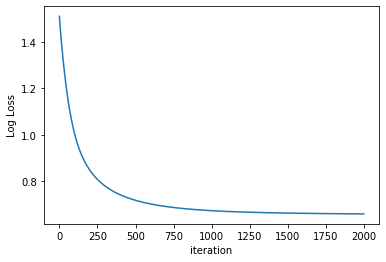

In [253]:
plt.plot(losses,'-')
plt.xlabel('iteration')
plt.ylabel('Log Loss')
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [260]:
ff_train = feedforward_2layer(params, logistic, X_train_tf)
y_train_preds = ff_train['A2'].T
ff_valid = feedforward_2layer(params, logistic, X_valid_tf)
y_valid_preds = ff_valid['A2'].T

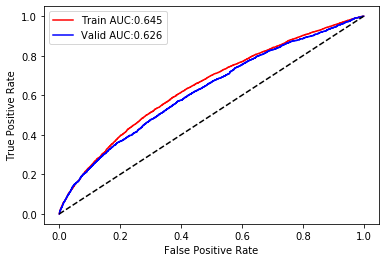

In [262]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)


plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Well that was quite slow to train. Let's use Keras (a deep learning framework) that has additional optimization routines like Adam which are faster. Keras is also great for building the neural network in just a few lines of code. 

# Keras

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [40]:
# make y labels that work nicely with Keras
y_train_keras = to_categorical(y_train,2)
y_valid_keras = to_categorical(y_valid,2)

y_train_keras.shape

(15766, 2)

In [95]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(64, activation = 'relu', 
                input_dim = X_train_tf.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(2, activation = 'softmax'))

In [96]:
# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [97]:
model.fit(X_train_tf, y_train_keras, 
          batch_size = 32, epochs= 5, 
          verbose = 1)

Epoch 1/5
15766/15766 [==============================] - 1s 65us/step - loss: 0.7466 - accuracy: 0.5733
Epoch 2/5
15766/15766 [==============================] - 1s 48us/step - loss: 0.6713 - accuracy: 0.6059
Epoch 3/5
15766/15766 [==============================] - 1s 49us/step - loss: 0.6576 - accuracy: 0.6158
Epoch 4/5
15766/15766 [==============================] - 1s 50us/step - loss: 0.6446 - accuracy: 0.6329
Epoch 5/5
15766/15766 [==============================] - 1s 51us/step - loss: 0.6417 - accuracy: 0.6333


In [98]:
y_train_preds_keras = model.predict_proba(X_train_tf,verbose = 1)[:,1]
y_valid_preds_keras = model.predict_proba(X_valid_tf,verbose = 1)[:,1]

14901/14901 [==============================] - 0s 14us/step


In [99]:
print('Train');
print_report(y_train[:,0], y_train_preds_keras, thresh=0.5)
print('Valid');
print_report(y_valid[:,0], y_valid_preds_keras, thresh=0.5);

Train
AUC:0.711
accuracy:0.652
recall:0.638
precision:0.657
specificity:0.667
prevalence:0.500
 
Valid
AUC:0.661
accuracy:0.626
recall:0.609
precision:0.173
specificity:0.628
prevalence:0.113
 


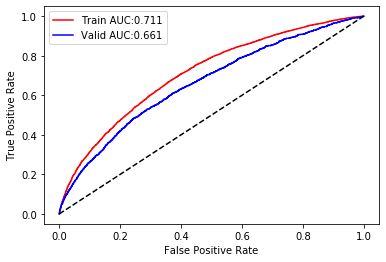

In [100]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_keras)
auc_train = roc_auc_score(y_train, y_train_preds_keras)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_keras)
auc_valid = roc_auc_score(y_valid, y_valid_preds_keras)


plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()